In [ ]:
import pandas as pd
import numpy as np
from math import radians, cos, sin, asin, sqrt

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from datetime import timedelta

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error

In [ ]:
route = pd.read_csv("/content/drive/MyDrive/Dataset/upa/preprocess/T-001_route2.csv",parse_dates=["Date from","Date to"])
route = route.iloc[:93,:]

In [ ]:
route.describe()

,Loaing Status,DFOC,Wave (per Distance),Acc. Fatigue Index,Wind (per Distance)
count,0.0,92.0,92.000000,92.000000,92.000000
mean,NaN,0.0,2.325000,362.041304,3.058696
std,NaN,0.0,1.164929,569.456791,1.455128
min,NaN,0.0,0.400000,0.300000,0.600000
25%,NaN,0.0,1.500000,43.450000,1.975000
50%,NaN,0.0,2.050000,123.550000,2.950000
75%,NaN,0.0,3.000000,415.400000,4.200000
max,NaN,0.0,5.900000,3183.700000,6.300000


In [ ]:
route = route[route["Acc. Fatigue Index"] <= 1500]

In [ ]:
route.drop(["Date from","Date to","Port from","Port to"],axis=1,inplace=True) # 모델링에 필요없는 데이터는 모두 삭제
route.drop(["Loaing Status","Mega-Ton-Mile","Cargo Carried","DFOC"],axis=1,inplace=True) # Mega-Ton-mile, Cargo Carried, DFOC 데이터의 경우 대부분이 0인 의미없는 데이터이기 때문에 모델링에서 제외

In [ ]:
scaler = MinMaxScaler()

route = pd.DataFrame(scaler.fit_transform(route),columns=route.columns) # 스케일을 맞춰주기 위해 MinMaxScaler로 스케일링 실시 (0~1)

In [ ]:
val_index = route.loc[route.days.isnull()].index # 기상 및 속도변수를 통해 도착지까지 걸리는 시간을 예측하는 회귀모형을 구축하는 것이 목표이기 때문에 days가 NaN값인 부분이 Validation set

In [ ]:
train_df = route.drop(val_index) # days가 NaN값을 갖지 않는 데이터를 train_df로 정의
val_df = route.loc[route.days.isnull()]
train_df.dropna(inplace=True)

In [ ]:
X_train.isnull().sum()

Distance               0
 T from                0
 T to                  0
Wave (per Distance)    0
Acc. Fatigue Index     0
Wind (per Distance)    0
Avg. Wave Heigh        0
Avg. Speed             0
Avg. Win Speed         0
dtype: int64

In [ ]:
val_df.isnull().sum() # validation df를 보면 days의 결측값이 7개인것을 확인 할 수 있는데 밑에 Avg speed에도 7개의 결측값이 있는 것을 확인 할 수 있음

days                   6
Distance               0
 T from                0
 T to                  0
Wave (per Distance)    0
Acc. Fatigue Index     0
Wind (per Distance)    0
Avg. Wave Heigh        0
Avg. Speed             6
Avg. Win Speed         0
dtype: int64

In [ ]:
X_val = val_df.drop("days",axis=1) 
X_val.interpolate(axis=1,inplace=True) # 결측치 처리를 먼저 interpolate을 통해 선형적으로 처리
X_val.reset_index(drop=True,inplace=True)

In [ ]:
X_train = train_df.drop("days",axis=1)
y_train = train_df.days

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train,y_train,test_size=0.1) # 테스트셋은 전체 train셋의 10%를 테스트셋으로 정의

In [ ]:
RFR = RandomForestRegressor()

RFR.fit(X_train,y_train)
pred = RFR.predict(X_test)
mse = mean_squared_error(y_test,pred)
print(round(mse,4)) # 테스트셋 정확도(MSE값)

0.0418


In [ ]:
feature_importance = RFR.feature_importances_.tolist()

([<matplotlib.patches.Wedge at 0x7f46895d4150>,
 [Text(0.9573045101816697, 0.5418192270359494, 'Distance'),
  Text(0.35120626963553964, 1.0424270507659943, '\xa0T from'),
  Text(-0.07294891154819418, 1.0975784510931026, '\xa0T to'),
  Text(-0.6078387993499681, 0.9168053195770569, 'Wave (per Distance)'),
  Text(-0.9622108103610928, -0.5330575545138154, 'Acc. Fatigue Index'),
  Text(0.19256797116334623, -1.0830131931246418, 'Wind (per Distance)'),
  Text(0.6862926862492239, -0.8596524581485384, 'Avg. Wave Heigh'),
  Text(1.0339345377988622, -0.37547219810080895, 'Avg. Speed'),
  Text(1.094270004771312, -0.11213008810213676, 'Avg. Win Speed')],
 [Text(0.5221660964627288, 0.2955377602014269, '16.39'),
  Text(0.19156705616483977, 0.5685965731450877, '6.87'),
  Text(-0.03979031538992409, 0.5986791551416922, '5.59'),
  Text(-0.33154843600907347, 0.5000756288602128, '10.93'),
  Text(-0.5248422601969597, -0.29075866609844475, '36.53'),
  Text(0.10503707518000702, -0.5907344689770774, '2.96'),
 

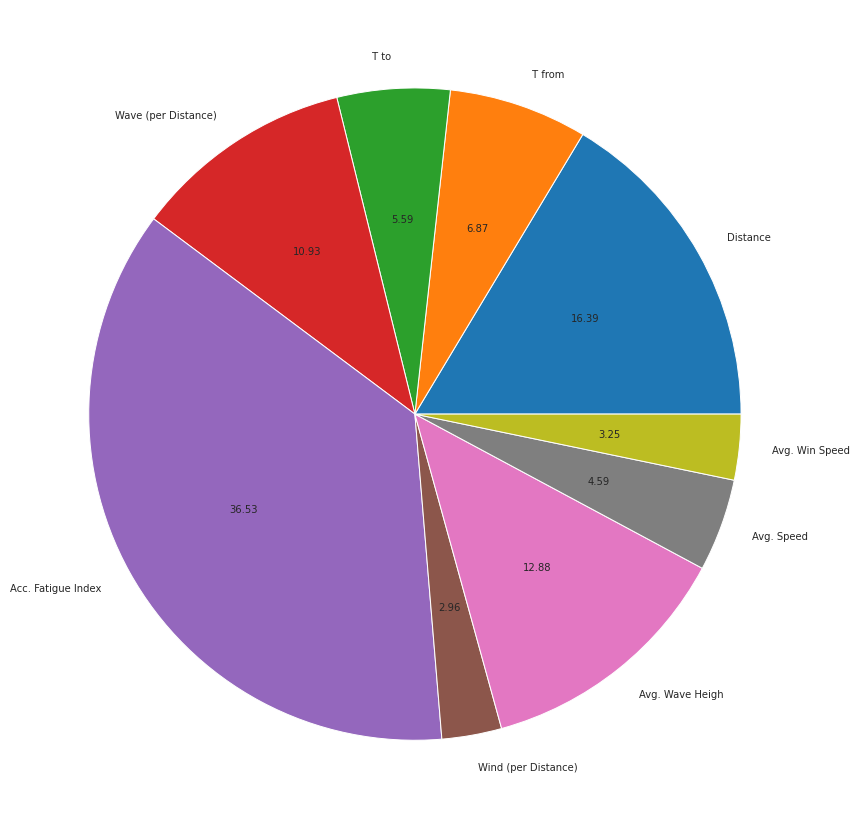

In [ ]:
sns.set_style("darkgrid")
plt.figure(figsize=(15,15))
plt.pie(feature_importance,labels=X_val.columns,autopct="%.2f")

# Validation set predction



In [ ]:
pred = RFR.predict(X_val)
pred_df = pd.DataFrame(pred,columns=["days"])

In [ ]:
result_df = pred_df.join(X_val)

In [ ]:
result_df = pd.DataFrame(scaler.inverse_transform(result_df),columns=train_df.columns)

In [ ]:
route = pd.read_csv("/content/drive/MyDrive/Dataset/upa/preprocess/T-001_route2.csv",parse_dates=["Date from","Date to"])

In [ ]:
 index = pd.DataFrame(route.loc[route.days.isnull()]["Date from"].to_list(),columns=["index"])
 result_df = pd.concat([result_df,index],axis=1)

In [ ]:
result_df.set_index("index",inplace=True)

In [ ]:
result_df

,days,Distance,T from,T to,Wave (per Distance),Acc. Fatigue Index,Wind (per Distance),Avg. Wave Heigh,Avg. Speed,Avg. Win Speed
index,,,,,,,,,,
2018-01-16 00:38:00,6.277,10585.0,15.0,15.0,1.3,635.7,6.3,1.3,8.853191,6.2
2018-02-11 18:05:00,2.416,82.0,12.0,9.0,0.9,68.8,1.3,1.4,2.519622,1.4
2018-04-02 22:16:00,1.977,40.0,9.0,13.0,1.3,47.5,2.3,1.6,4.046927,2.3
2018-04-21 22:13:00,3.540,70.0,11.0,9.0,2.9,1100.5,3.2,2.9,9.445705,4.8
2018-10-11 23:44:00,6.233,3672.0,9.0,17.0,1.9,509.0,3.2,2.0,6.020055,3.3
2018-10-26 16:54:00,4.268,9359.0,12.0,9.0,0.9,168.4,4.7,0.9,6.068952,4.6
2018-11-29 20:28:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
